In [ ]:
# https://curiousily.com/posts/intent-recognition-with-bert-using-keras-and-tensorflow-2/
!pip install transformers

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.4.1


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
#import torch
#import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

# text preprocessing
from nltk.tokenize import word_tokenize
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, Model, model_from_json


# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, MaxPooling1D, Dropout, Flatten

import nltk
nltk.download('punkt')
nltk.download('words')
words = set(nltk.corpus.words.words())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
folder_path = '/content/drive/My Drive/Multi-Task-W2V/data/pos-neg/'
data= pd.read_csv(folder_path + 'combine_con-ama.csv')
data.head()

,text,label
0,I've really been working a lot lately.,neutral
1,The stock market crashed.,negative
2,Everybody loves pizza.,positive
3,"If I make an exception for you, I have to do i...",negative
4,"If I have large bills, should I break them whi...",neutral


In [ ]:
data.tail()

,text,label
25182,"I'm sorry, but we're booked up on Friday.",negative
25183,There's nothing I can think of.,neutral
25184,"I've been looking for a long time, and I final...",positive
25185,I don't care. I'm going to be late for work.,negative
25186,"Oh, not again! You're calling about the rent.",negative


In [ ]:
#Defining functions for Cleaning and Normalization of Data
import re
import string
def replace_url(string): # cleaning of URL
    text = re.sub(r'http\S+', 'LINK', string)
    return text


def replace_email(text):#Cleaning of Email related text
    line = re.sub(r'[\w\.-]+@[\w\.-]+','MAIL',str(text))
    return "".join(line)

def rep(text):#cleaning of non standard words
    grp = text.group(0)
    if len(grp) > 3:
        return grp[0:2]
    else:
        return grp# can change the value here on repetition
def unique_char(rep,sentence):
    convert = re.sub(r'(\w)\1+', rep, sentence) 
    return convert

def find_dollar(text):#Finding the dollar sign in the text
    line=re.sub(r'\$\d+(?:\.\d+)?','PRICE',text)
    return "".join(line)

def replace_emoji(text):
    emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F" # emoticons
    u"\U0001F300-\U0001F5FF" # symbols & pictographs
    u"\U0001F680-\U0001F6FF" # transport & map symbols
    u"\U0001F1E0-\U0001F1FF" # flags (iOS)
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'EMOJI', text) 

puncts = [':', ')', '(', '-', '!', '?', '|', ';', '$', '&', '/', '[', ']','ª',
          '>', '%', '=', '#', '*', '+', '\\', '•', '~', '@', '£', '·', '_', '{', '}', '©', '^',
          '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 'Â', '█',
          '½', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶',
          '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼',
          '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
          'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪',
          '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√']

def clean_text(text: str) -> str:
    text = str(text)
    for punct in puncts:
        if punct in text:
            text = text.replace(punct, f' ')
    return text
   
def replace_asterisk(text):
    text = re.sub("\*", 'ABUSE ', text)
    return text

def remove_duplicates(text):
    text = re.sub(r'\b(\w+\s*)\1{1,}', '\\1', text)
    return text
def remove_numbers(text):
    text = re.sub("(\s\d+)"," ",text) 
    return text
def change(text):
    if(text == ''):
        return text
  #calling the subfunctions in the cleaning function
    text = text.lower()
    text = replace_email(text)
    text = replace_url(text)
    text = unique_char(rep,text)
    #text = replace_asterisk(text)
    text = remove_duplicates(text)
    text = clean_text(text)
    text = remove_numbers(text)
    text = text.strip()
    return text

In [ ]:
data['clean_sentence'] = data['text'].apply(lambda x : change(x))

In [ ]:
data.head()

,text,label,clean_sentence
0,I've really been working a lot lately.,neutral,i've really been working a lot lately.
1,The stock market crashed.,negative,the stock market crashed.
2,Everybody loves pizza.,positive,everybody loves pizza.
3,"If I make an exception for you, I have to do i...",negative,"if i make an exception for you, i have to do i..."
4,"If I have large bills, should I break them whi...",neutral,"if i have large bills, should i break them whi..."


In [ ]:
for i in range(50):
  print(data.text[i])
  print(data.clean_sentence[i])
  print('*')

In [ ]:
data.label.value_counts()

neutral     12736
positive     6760
negative     5691
Name: label, dtype: int64

In [ ]:
temp_neu = []
for i in range(len(data)):
  if data.label[i] == 'neutral':
    temp_neu.append(i)

len(temp_neu)

12736

In [ ]:
df1 = data.drop(data.index[temp_neu[5670:]]).reset_index(drop=True)

In [ ]:
temp_pos = []
for i in range(len(df1)):
  if df1.label[i] == 'positive':
    temp_pos.append(i)

len(temp_pos)

6760

In [ ]:
df2 = df1.drop(df1.index[temp_pos[5700:]]).reset_index(drop=True)

In [ ]:
df2.label.value_counts()

positive    5700
negative    5691
neutral     5670
Name: label, dtype: int64

In [ ]:
final_df = df2
final_df.tail()

,text,label
17056,That's not a vacation. But I may have to do th...,negative
17057,But I have tickets to a game.,negative
17058,"I'm sorry, but we're booked up on Friday.",negative
17059,I don't care. I'm going to be late for work.,negative
17060,"Oh, not again! You're calling about the rent.",negative


In [ ]:
final_df.label.value_counts(), final_df.shape

(positive    5700
 negative    5691
 neutral     5670
 Name: label, dtype: int64, (17061, 2))

**Steps For Extracting Contexual Embeddings from Distilbert/BERT**

In [ ]:
# import 
from transformers import BertTokenizer, TFBertModel, BertConfig
from transformers import DistilBertTokenizer, TFDistilBertModel
from transformers import RobertaTokenizer, TFRobertaModel


distil_bert = 'distilbert-base-uncased' # Name of the pretrained models
bert = 'bert-base-uncased'
roberta = 'roberta-base'

#BERT 
tokenizer = RobertaTokenizer.from_pretrained(roberta)
model = TFRobertaModel.from_pretrained(roberta)

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
# obtain the 768-dim vector correpsoding to [CLS] which is a sentence vector
e = tokenizer.encode("Hello my dog is cute", add_special_tokens=False)
print(e)

input = tf.constant(e)[None, :]  # Batch size 1 
print(input)
print(type(input)) # shape: [1,8]

output = model(input)

print(type(output))
print(len(output))
print(output) #shape[1,8,768]

[31414, 127, 2335, 16, 11962]
tf.Tensor([[31414   127  2335    16 11962]], shape=(1, 5), dtype=int32)
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'transformers.modeling_tf_outputs.TFBaseModelOutputWithPooling'>
2
TFBaseModelOutputWithPooling(last_hidden_state=<tf.Tensor: shape=(1, 5, 768), dtype=float32, numpy=
array([[[-0.06269638,  0.09041426, -0.02503841, ..., -0.09746335,
         -0.06634366, -0.0101432 ],
        [-0.07917143,  0.03119747, -0.03275252, ..., -0.4369618 ,
          0.01261801, -0.14185679],
        [-0.01492394,  0.17120346,  0.05356141, ..., -0.22804178,
          0.05512724,  0.09385805],
        [ 0.01351722,  0.20617127,  0.06503488, ..., -0.3589927 ,
          0.05936863, -0.05684781],
        [ 0.10702726,  0.20793653, -0.03190684, ...,  0.14049453,
          0.04335402,  0.02932693]]], dtype=float32)>, pooler_output=<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-0.00802025, -0.21904732, -0.2016452 , -0.08229407,  0.11633433,
    

In [ ]:
model

In [ ]:
text = final_df.text[2700]
print(text)
e = tokenizer.encode(text, add_special_tokens=False)
print(len(e))
print(e)
temp_split = tokenizer.tokenize(text)
print(len(temp_split))
print(temp_split)

Is the suspect in this line-up?
9
[6209, 5, 1985, 11, 42, 516, 12, 658, 116]
9
['Is', 'Ġthe', 'Ġsuspect', 'Ġin', 'Ġthis', 'Ġline', '-', 'up', '?']


In [ ]:
final_df.text[2700]

'Is the suspect in this line-up?'

In [ ]:
text = "Replace me by any text you'd like."
encoded_input = tokenizer.tokenize(text)

In [ ]:
encoded_input

['Re', 'place', 'Ġme', 'Ġby', 'Ġany', 'Ġtext', 'Ġyou', "'d", 'Ġlike', '.']

**Create function for Mapping Words to ids and Word Embeddings**

In [ ]:
# sentence wise contextual embeddings
def word_ids_embeddings(dataframe):
  word_ids = {} # index of words => word->ids, ex:'for'->2005, 
  word_embeddings = {} # word->embeddings 
  dummy_index = [] # if both tokenization lengths are not matching
  for i in tqdm(range(len(dataframe))):
    text = str(dataframe.text[i])
    e = tokenizer.encode(text, add_special_tokens=False) # token ids
    text_token = tokenizer.tokenize(text)
    input = tf.constant(e)[None, :]  # Batch size 1 
    output = model(input)[0][0]
    if len(e) == len(output) == len(text_token):
      for j in range(len(e)):
        word_ids[text_token[j]] = e[j] # word->ids
        final_out = np.asarray(output[j]) # convert as numpy array
        word_embeddings[text_token[j]] = final_out # word->embeddings
    else:
      dummy_index.append(i) # if lengths are not matching
  return word_ids, word_embeddings, dummy_index

In [ ]:
word_ids, word_embeddings, dummy_index = word_ids_embeddings(final_df)
len(word_ids), len(word_embeddings), len(dummy_index)

100%|██████████| 17061/17061 [1:00:50<00:00,  4.67it/s]


(10250, 10250, 0)

In [ ]:
# save ids words->ids as vocab.txt file
import os
for key, value in word_ids.items(): 
  #print(key, value[0])
  temp = key +" "+str(value)
  with open('vocab-v1.txt', 'a') as f1:
    f1.write(temp + os.linesep)

In [ ]:
# max vocab
max_vocab = []
index_of_words = word_ids
for key, value in word_embeddings.items():
  if key in index_of_words:
    idx = index_of_words[key]
    max_vocab.append(idx)

max(max_vocab) # 29591, 29659

50141

In [ ]:
def create_embedding_matrix(max_vocab, word_embeddings, word_index, embedding_dim):
    vocab_size = max(max_vocab) + 1  # Adding again 1 because of reserved 0 index 29567-all ids 
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, vector in word_embeddings.items():
      if word in word_index:
        idx = word_index[word] 
        #print(idx, word)
        embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [ ]:
embed_num_dims = 300 # 768, 300, 100
index_of_words = word_ids
embedd_matrix = create_embedding_matrix(max_vocab, word_embeddings, index_of_words, embed_num_dims)
embedd_matrix.shape

(50142, 300)

In [ ]:
# Embedding layer before the actaul BLSTM 
vocab_size = max(max_vocab) + 1
max_seq_len = 100
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

In [ ]:
# Convolution
kernel_size = 3
filters = 256
num_classes =3
model_cnn = Sequential()
model_cnn.add(embedd_layer)
model_cnn.add(Conv1D(filters, kernel_size, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(256, activation='relu'))
model_cnn.add(Dense(num_classes, activation='softmax'))
model_cnn.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          15042600  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 98, 256)           230656    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 771       
Total params: 15,339,819
Trainable params: 297,219
Non-trainable params: 15,042,600
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# path to save weights
#path_w = '/content/drive/My Drive/DataToBiz/speech_to_emotion_engine/models/'
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
checkpointer = ModelCheckpoint(filepath='weights_datasetv2_cnnv2.hdf5', verbose=1, save_best_only=True)

In [ ]:
final_df.shape

(17061, 2)

In [ ]:
final_df.head()

,text,label
0,I've really been working a lot lately.,neutral
1,The stock market crashed.,negative
2,Everybody loves pizza.,positive
3,"If I make an exception for you, I have to do i...",negative
4,"If I have large bills, should I break them whi...",neutral


In [ ]:
# split dataset
from sklearn.model_selection import train_test_split
X = final_df.text
y = final_df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state =42, shuffle=True)
print(X_train.shape)
print(X_test.shape)

(15354,)
(1707,)


In [ ]:
# tokenization
X_train_tokenized = X_train.apply((lambda x: tokenizer.encode(x, add_special_tokens=False)))
X_test_tokenized = X_test.apply((lambda x: tokenizer.encode(x, add_special_tokens=False)))

In [ ]:
# padding
max_seq_len = 100
X_train_pad = pad_sequences(X_train_tokenized, maxlen = max_seq_len, padding='post')
X_test_pad = pad_sequences(X_test_tokenized, maxlen = max_seq_len, padding='post')
X_train_pad

array([[ 2264,    59,  7893, ...,     0,     0,     0],
       [  894,    34,  2710, ...,     0,     0,     0],
       [14783,     6,    14, ...,     0,     0,     0],
       ...,
       [ 1185,   240,     7, ...,     0,     0,     0],
       [ 1708,    24,   473, ...,     0,     0,     0],
       [  100,    56,   239, ...,     0,     0,     0]], dtype=int32)

In [ ]:
encoding = {'negative': 0, 'neutral': 1, 'positive': 2}
# Integer labels
y_train = [encoding[x] for x in y_train]
y_test = [encoding[x] for x in y_test]

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [ ]:
batch_size = 12
epochs = 30

hist = model_cnn.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test), 
                 callbacks=[early_stopping, checkpointer])

Epoch 1/30
1280/1280 [==============================] - 38s 30ms/step - loss: 0.5310 - accuracy: 0.7596 - val_loss: 0.4011 - val_accuracy: 0.8190

Epoch 00001: val_loss improved from inf to 0.40105, saving model to weights_datasetv2_cnnv2.hdf5
Epoch 2/30
1280/1280 [==============================] - 38s 29ms/step - loss: 0.2778 - accuracy: 0.8769 - val_loss: 0.3364 - val_accuracy: 0.8576

Epoch 00002: val_loss improved from 0.40105 to 0.33635, saving model to weights_datasetv2_cnnv2.hdf5
Epoch 3/30
1280/1280 [==============================] - 37s 29ms/step - loss: 0.2040 - accuracy: 0.9139 - val_loss: 0.3379 - val_accuracy: 0.8658

Epoch 00003: val_loss did not improve from 0.33635
Epoch 4/30
1280/1280 [==============================] - 37s 29ms/step - loss: 0.1373 - accuracy: 0.9448 - val_loss: 0.3805 - val_accuracy: 0.8653

Epoch 00004: val_loss did not improve from 0.33635
Epoch 5/30
1280/1280 [==============================] - 37s 29ms/step - loss: 0.1012 - accuracy: 0.9598 - val_lo

In [ ]:
# Save the model to disk
model_json = model_cnn.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# loading json and model architecture 
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("weights_datasetv2_cnnv2.hdf5")
print("Model Loaded")

# the optimiser
loaded_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

Model Loaded


In [ ]:
class_names = ['negative', 'neutral', 'positive']
predictions = loaded_model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

In [ ]:
y_test1 = np.argmax(y_test, axis=1)
y_test1 = [class_names[x] for x in y_test1]

In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test1, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test1, predictions, average='micro') * 100))

Accuracy: 85.76%

F1 Score: 85.76


In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


F1 Score: 85.76


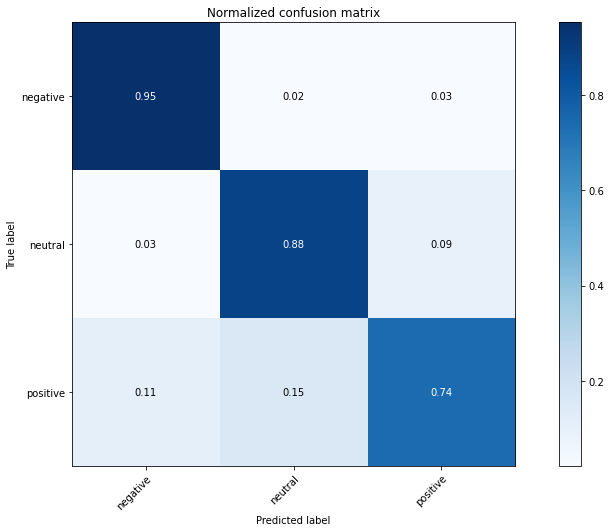

In [ ]:
print("\nF1 Score: {:.2f}".format(f1_score(y_test1, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(y_test1, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
loaded_model.save("my_model2")

INFO:tensorflow:Assets written to: my_model2/assets


In [ ]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_saved_model("my_model2")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_quant_model)

In [ ]:
text = "good keep going"
tokens= tokenizer.encode(text, add_special_tokens=False)
len1 = 100 - len(tokens)
for i in range(len1):
  tokens.append(0)

tokens = np.asarray(tokens)
tok = np.expand_dims(tokens, axis=0)
out = model_cnn.predict(tok)
predictions1 = np.argmax(out, axis=1)
pred1 = [class_names[pred] for pred in predictions1]
pred1

['positive']

In [ ]:
for text, label in zip(X_test, y_test):
  print(text, '-->', label)
  print('\n')